[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Example 6.15

Clustering of NBA players between 1996 and 2019 based on their rebounds and assists per game\
Topics: Gaussian mixture model, expectation maximization algorithm, clustering, unsupervised learning

Author: Carlos Fernandez-Granda\
Data source: http://www.kaggle.com/datasets/justinas/nba-players-data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy import stats
from sklearn.mixture import GaussianMixture
from matplotlib.lines import Line2D

data = pd.read_csv ("../data/nba_all_seasons.csv", encoding='latin-1')

font_size = 15
font_size_legend = 15
font_size_ticks = 15

height = data['player_height']
points = data['pts']
rebounds = data['reb']
assists = data['ast']

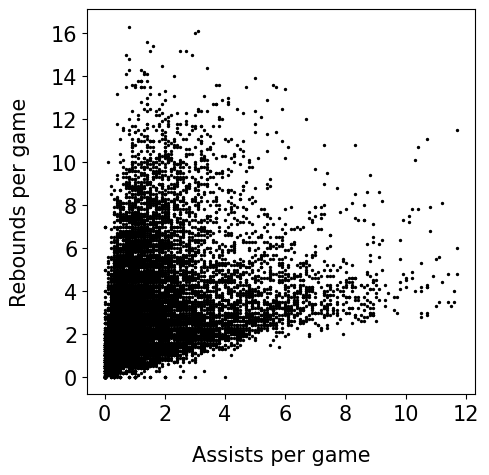

In [2]:
markersize =2
plt.figure(figsize=(5,5))
plt.scatter(assists,rebounds,s=markersize,color="black")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel('Assists per game',fontsize=font_size,labelpad = 15)
plt.ylabel('Rebounds per game',fontsize=font_size,labelpad = 15);

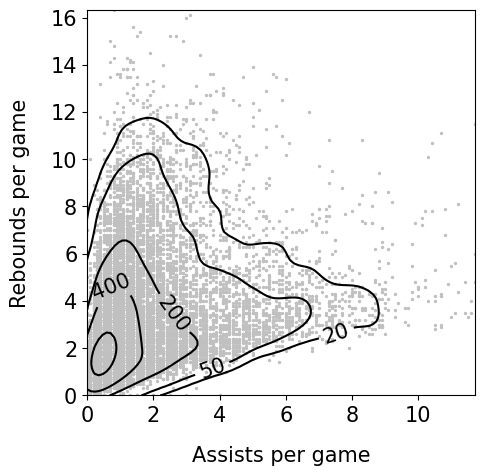

In [3]:
# Kernel density estimation of the 2D joint pdf of rebounds and assists
def KDE_2D(data_1,data_2,x,y,bw=None):
    grid = np.vstack([x.ravel(), y.ravel()])
    values = np.vstack([data_1, data_2])
    kernel = stats.gaussian_kde(values,bw_method=bw)
    kde = np.reshape(kernel(grid).T, x.shape)
    return kde

def fmt(x):
    s = f"{x:.4f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

rebounds_min = np.min(rebounds)
rebounds_max = np.max(rebounds)
assists_min = np.min(assists)
assists_max = np.max(assists)

assists_rebounds_x,assists_rebounds_y = np.mgrid[assists_min:assists_max:100j, rebounds_min:rebounds_max:100j]

bw_vals = [0.2]
levels = [20,50,200,400,800]
alpha = 1

for ind,bw in enumerate(bw_vals):
    kde = KDE_2D(assists,rebounds,assists_rebounds_x,assists_rebounds_y,bw=bw)
    plt.figure(figsize=(5,5))
    plt.scatter(assists,rebounds,s=markersize,color="silver",alpha=alpha,rasterized=True)
    CS = plt.contour(assists_rebounds_x,assists_rebounds_y, 1e4*kde, levels=levels,colors='black')
    plt.clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=font_size_ticks)
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    #plt.ylim([assists_min,points_max])
    #plt.xlim([height_min,height_max])
    plt.xlabel('Assists per game',fontsize=font_size,labelpad = 15)
    plt.ylabel('Rebounds per game',fontsize=font_size,labelpad = 15);

In [4]:
def gaussian(x,y,mu,invSigma,Sigma):
    return (np.exp(-(invSigma[0,0] * (x-mu[0])**2 + 2*invSigma[0,1]*(x-mu[0])*(y-mu[1]) + invSigma[1,1] * (y-mu[1])**2)/2)
                  /(2 * np.pi * np.sqrt(np.linalg.det(Sigma))))

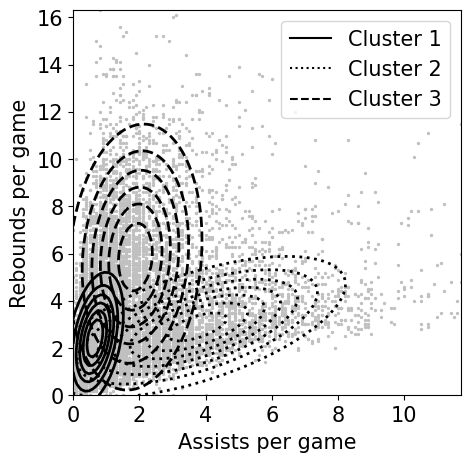

In [5]:
# Gaussian mixture model with 3 components, fit to the data via expectation maximization
X = np.vstack((assists,rebounds))
gm = GaussianMixture(n_components=3, random_state=0).fit(X.T)
mu_1 = gm.means_[0,:]
Sigma_1 = gm.covariances_[0,:,:]
invSigma_1 = np.linalg.inv(Sigma_1)
z_gaussian_1 = gaussian(assists_rebounds_x,assists_rebounds_y,mu_1,invSigma_1,Sigma_1)
mu_2 = gm.means_[1,:]
Sigma_2 = gm.covariances_[1,:,:]
invSigma_2 = np.linalg.inv(Sigma_2)
z_gaussian_2 = gaussian(assists_rebounds_x,assists_rebounds_y,mu_2,invSigma_2,Sigma_2)
mu_3 = gm.means_[2,:]
Sigma_3 = gm.covariances_[2,:,:]
invSigma_3 = np.linalg.inv(Sigma_3)
z_gaussian_3 = gaussian(assists_rebounds_x,assists_rebounds_y,mu_3,invSigma_3,Sigma_3)

levels_gaussian = [0.1,1,5]
alpha = 1

plt.figure(figsize=(5,5))
plt.scatter(assists,rebounds,s=markersize,color="silver",alpha=alpha,rasterized=True)
CS_1 = plt.contour(assists_rebounds_x,assists_rebounds_y,z_gaussian_1, levels=8,colors='black',linewidths=2)
CS_2 = plt.contour(assists_rebounds_x,assists_rebounds_y,z_gaussian_2, levels=8,colors='black',linestyles='dotted',linewidths=2)
CS_3 = plt.contour(assists_rebounds_x,assists_rebounds_y,z_gaussian_3, levels=8,colors='black',linestyles='dashed',linewidths=2)
proxy_1 = Line2D([0], [0], color=CS_1.cmap(0.5),ls="solid", label="Cluster 1")
proxy_2 = Line2D([0], [0], color=CS_2.cmap(0.5),ls="dotted", label="Cluster 2")
proxy_3 = Line2D([0], [0], color=CS_3.cmap(0.5),ls="dashed", label="Cluster 3")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.legend(handles=[proxy_1,proxy_2,proxy_3],fontsize=font_size)
plt.xlabel('Assists per game',fontsize=font_size,labelpad = 5)
plt.ylabel('Rebounds per game',fontsize=font_size,labelpad = 5);

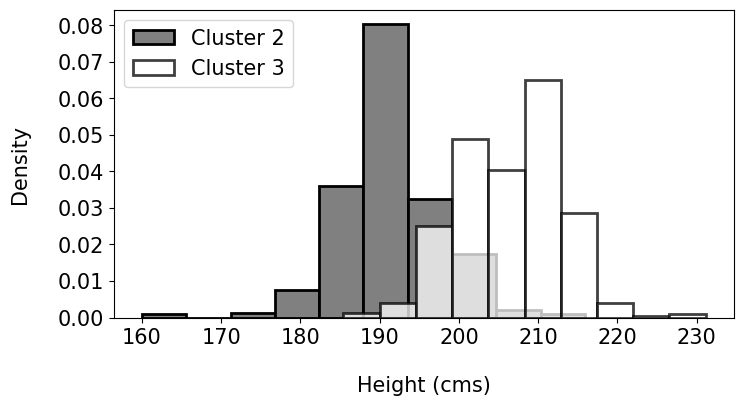

In [6]:
assigned_cluster = gm.predict(X.T)
height_1 = height[assigned_cluster==0]
height_2 = height[assigned_cluster==1]
height_3 = height[assigned_cluster==2]
plt.figure(figsize=(8,4))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
#plt.xlim([assists_min_hist,assists_max])
plt.hist(height_2,#bins=n_bins,log=True,
         color='gray', edgecolor='black',
          linewidth=2,density=True,label="Cluster 2")
plt.hist(height_3,#bins=n_bins,log=True,
         color='white', edgecolor='black',alpha=0.75,
          linewidth=2,density=True,label="Cluster 3")
plt.xlabel("Height (cms)",fontsize=font_size,labelpad=20)
plt.ylabel("Density",fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,loc="upper left");